# Automating a medical image segmentation problem

In this lab you will be automating a real medical imaging problem.

You will be building a system for prostate gland segmentation on MR images. The dataset is provided [here](https://github.com/s-sd/EMS741/tree/main/tutorials/images).

With this data, there is a known problem, segmentation NNs do not do very well when the prostate gland is not present in the image i.e., they create false positives.

As such, you will need to build a system which:
1) classifies an image as prostate gland present vs absent
2) segment gland using a segmentation NN only if gland present

This will require two neural networks corresponding to the two tasks above. Your task in this lab is to build, train and evaluate (quantitatively and qualitatively) these two NNs using the given dataset.

Then you should write a function, which takes in an image and returns the segmentation if the gland is present, or returns a null value if the gland is absent.

Optional: Compare this two-step approach against a segmentation network which does not have the first, presence classification, step.

### Download the dataset

In [167]:
!wget -O images_lab_data.zip https://github.com/s-sd/EMS741/raw/refs/heads/main/tutorials/images/images_lab_data.zip

--2026-02-20 17:11:18--  https://github.com/s-sd/EMS741/raw/refs/heads/main/tutorials/images/images_lab_data.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/s-sd/EMS741/refs/heads/main/tutorials/images/images_lab_data.zip [following]
--2026-02-20 17:11:18--  https://raw.githubusercontent.com/s-sd/EMS741/refs/heads/main/tutorials/images/images_lab_data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23924619 (23M) [application/zip]
Saving to: ‘images_lab_data.zip’

images_lab_data.zip 100%[===================>]  22.82M  --.-KB/s    in 0.05s   

2026-02-20 17:11:20 (444 MB/s) - ‘images

In [168]:
import zipfile
import os

path_to_zip = r'images_lab_data.zip'
path_to_extract_to = r'./'

with zipfile.ZipFile(path_to_zip, 'r') as zip_ref:
    zip_ref.extractall(path_to_extract_to)

In [169]:
!ls

# we are interested in 'images' and 'masks'

images	images_lab_data.zip  masks  sample_data


### Data checks

Before you proceed with building your segmentation system, load in a single image and corresponding mask to verify that they are paired correctly. And to check their shapes etc. Hint: use the matplotlib imread function.

In [170]:
import matplotlib.pyplot as plt
import numpy as np

images_file_names = np.array(sorted(os.listdir('images')))
masks_file_names = np.array(sorted(os.listdir('masks')))

#shuffle the image and masks using the same order
shuffle_indexes = np.array(np.random.permutation(len(images_file_names)), dtype=np.int32)

images_file_names_shuffled = images_file_names[shuffle_indexes]
masks_file_names_shuffled = masks_file_names[shuffle_indexes]

print(images_file_names_shuffled[0], masks_file_names_shuffled[0])

sample_249_slice_011.png sample_249_slice_011.png


images/sample_70_slice_020.png masks/sample_70_slice_020.png


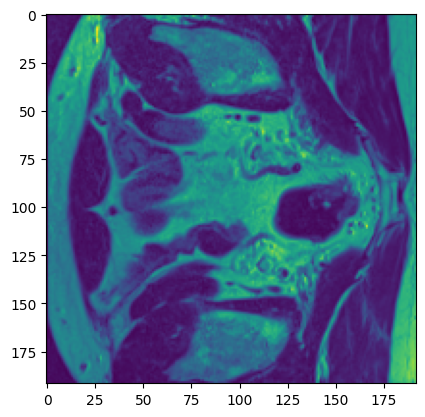

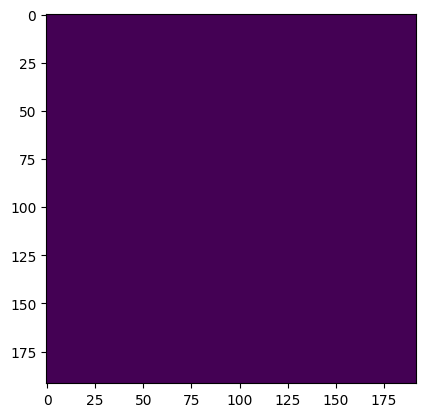

In [171]:
sample_number_to_plot = 10

image_path = os.path.join(r'images', images_file_names_shuffled[sample_number_to_plot])
mask_path = os.path.join(r'masks', masks_file_names_shuffled[sample_number_to_plot])

print(image_path, mask_path)

image = plt.imread(image_path)
mask = plt.imread(mask_path)

plt.imshow(image)

plt.figure()
plt.imshow(mask)

In [172]:
print(np.amin(image), np.amax(image))
print(np.amin(mask), np.amax(mask))
print(image.shape, mask.shape)

# this is what we can use to quickly get a classification label
# if the sum of all pixels in the mask is >1 then prostate exists
# if the sum is 0 then prostate does not exist
print(int(np.sum(mask, axis=None)>1))

0.0 1.0
0.0 0.0
(192, 192) (192, 192)
0


### Your segmentation approach

Now it's time to build your segmentation system

In [173]:
# python generator for classification

def my_classification_data_generator(batch_size, x_shape, y_shape, file_names, images_file_path, masks_file_path):

  while True:

    batch_x = np.zeros((batch_size, *x_shape))
    batch_y = np.zeros((batch_size, *y_shape))

    for i in range(batch_size):

      index = np.random.randint(len(file_names))

      image = plt.imread(os.path.join(images_file_path, file_names[index]))

      mask = plt.imread(os.path.join(masks_file_path, file_names[index]))
      classification = int(np.sum(mask, axis=None)>1)

      batch_x[i] = image
      batch_y[i] = classification

    batch_x = np.expand_dims(batch_x, axis=-1)

    yield batch_x, batch_y


In [174]:
import tensorflow as tf

# build a simple convolutional alexnet style architecture

image_shape = [*image.shape, 1]
print(image_shape)


def build_minimal_alexnet(input_shape=image_shape):

    inputs = tf.keras.Input(shape=input_shape)

    x = tf.keras.layers.Conv2D(64, (11, 11), strides=4, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2)(x)
    x = tf.keras.layers.Conv2D(192, (5, 5), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2)(x)
    x = tf.keras.layers.Conv2D(384, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


classification_model = build_minimal_alexnet()
classification_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
classification_model.summary()

[192, 192, 1]


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 192, 192, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_230 (Conv2D)             │ (None, 48, 48, 64)     │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_57 (MaxPooling2D) │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_231 (Conv2D)             │ (None, 23, 23, 192)    │       307,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_58 (MaxPooling2D) │ (None, 11, 11, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_232 (Conv2D)             │ (None, 11, 11, 384)    │       663,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_233 (Conv2D)             │ (None, 11, 11, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_59 (MaxPooling2D) │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,141,953 (19.61 MB)

 Trainable params: 5,141,953 (19.61 MB)

 Non-trainable params: 0 (0.00 B)

In [175]:
# split file names into relevant sets

train_val_test_ratio = [0.6, 0.2, 0.2]

num_files = len(images_file_names_shuffled)

train_val_test_ratio = [0.6, 0.2, 0.2]

train_index_start = 0
train_index_end = int(train_val_test_ratio[0] * num_files)

val_index_start = train_index_end
val_index_end = val_index_start + int(train_val_test_ratio[1] * num_files)

test_index_start = val_index_end
test_index_end = test_index_start + int(train_val_test_ratio[2] * num_files)

train_file_names = images_file_names_shuffled[train_index_start:train_index_end]
val_file_names = images_file_names_shuffled[val_index_start:val_index_end]
test_file_names = images_file_names_shuffled[test_index_start:test_index_end]


In [176]:
# train model

batch_size = 64
x_shape = image.shape
y_shape = [1]
images_file_path = r'images'
masks_file_path = r'masks'

train_gen = my_classification_data_generator(batch_size, x_shape, y_shape, train_file_names, images_file_path, masks_file_path)

val_gen = my_classification_data_generator(batch_size, x_shape, y_shape, val_file_names, images_file_path, masks_file_path)

history = classification_model.fit(
    train_gen,
    steps_per_epoch=128,
    epochs=4,
    validation_data=val_gen,
    validation_steps=8,
    verbose=1
)

Epoch 1/4
128/128 ━━━━━━━━━━━━━━━━━━━━ 20s 125ms/step - accuracy: 0.7792 - loss: 0.5576 - val_accuracy: 0.8359 - val_loss: 0.3356
Epoch 2/4
128/128 ━━━━━━━━━━━━━━━━━━━━ 15s 118ms/step - accuracy: 0.9317 - loss: 0.1829 - val_accuracy: 0.9609 - val_loss: 0.3024
Epoch 3/4
128/128 ━━━━━━━━━━━━━━━━━━━━ 15s 115ms/step - accuracy: 0.9920 - loss: 0.0274 - val_accuracy: 0.9688 - val_loss: 0.1472
Epoch 4/4
128/128 ━━━━━━━━━━━━━━━━━━━━ 14s 110ms/step - accuracy: 0.9949 - loss: 0.0173 - val_accuracy: 0.9473 - val_loss: 0.3923


Text(0, 0.5, 'loss')

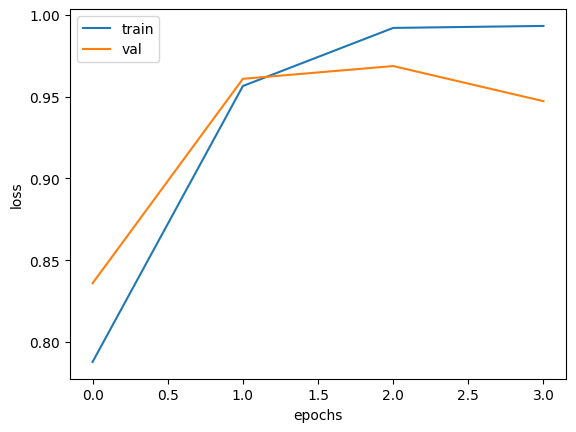

In [177]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.legend(['train', 'val'])
plt.xlabel('epochs')
plt.ylabel('loss')

In [178]:
test_gen = my_classification_data_generator(batch_size, x_shape, y_shape, test_file_names, images_file_path, masks_file_path)

loss, acc = classification_model.evaluate(test_gen, steps=64, verbose=1)

64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.9251 - loss: 0.5316


### Now let's do a segmentation model

In [179]:
# data generator for segmentation

def my_segmentation_data_generator(batch_size, x_shape, y_shape, file_names, images_file_path, masks_file_path):

  while True:

    batch_x = np.zeros((batch_size, *x_shape))
    batch_y = np.zeros((batch_size, *y_shape))

    for i in range(batch_size):

      index = np.random.randint(len(file_names))

      image = plt.imread(os.path.join(images_file_path, file_names[index]))
      mask = plt.imread(os.path.join(masks_file_path, file_names[index]))

      batch_x[i] = image
      batch_y[i] = mask

    batch_x = np.expand_dims(batch_x, axis=-1)
    batch_y = np.expand_dims(batch_y, axis=-1)

    yield batch_x, batch_y

In [180]:
# build a Unet model

image_shape = [*image.shape, 1]
print(image_shape)

def build_simple_unet(input_shape=image_shape, out_channels=1):

    inputs = tf.keras.Input(shape=input_shape)

    x = tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    s1 = x # skip connection
    x = tf.keras.layers.MaxPooling2D()(x)

    x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    s2 = x
    x = tf.keras.layers.MaxPooling2D()(x)

    x = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    s3 = x
    x = tf.keras.layers.MaxPooling2D()(x)

    x = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(x)

    x = tf.keras.layers.UpSampling2D()(x)
    x = tf.keras.layers.Concatenate()([x, s3])
    x = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x)

    x = tf.keras.layers.UpSampling2D()(x)
    x = tf.keras.layers.Concatenate()([x, s2])
    x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)

    x = tf.keras.layers.UpSampling2D()(x)
    x = tf.keras.layers.Concatenate()([x, s1])
    x = tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu')(x)

    outputs = tf.keras.layers.Conv2D(out_channels, 1, padding='same', activation='sigmoid' if out_channels == 1 else 'softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


segmentation_model = build_simple_unet(input_shape=image_shape, out_channels=1)
segmentation_model.compile(optimizer='adam', loss='binary_crossentropy')
segmentation_model.summary()

[192, 192, 1]


Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20      │ (None, 192, 192,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_234 (Conv2D) │ (None, 192, 192,  │        320 │ input_layer_20[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_235 (Conv2D) │ (None, 192, 192,  │      9,248 │ conv2d_234[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_60    │ (None, 96, 96,    │          0 │ conv2d_235[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_236 (Conv2D) │ (None, 96, 96,    │     18,496 │ max_pooling2d_60… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_237 (Conv2D) │ (None, 96, 96,    │     36,928 │ conv2d_236[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_61    │ (None, 48, 48,    │          0 │ conv2d_237[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_238 (Conv2D) │ (None, 48, 48,    │     73,856 │ max_pooling2d_61… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_239 (Conv2D) │ (None, 48, 48,    │    147,584 │ conv2d_238[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_62    │ (None, 24, 24,    │          0 │ conv2d_239[0][0]  │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_240 (Conv2D) │ (None, 24, 24,    │    295,168 │ max_pooling2d_62… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_241 (Conv2D) │ (None, 24, 24,    │    590,080 │ conv2d_240[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_42    │ (None, 48, 48,    │          0 │ conv2d_241[0][0]  │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_42      │ (None, 48, 48,    │          0 │ up_sampling2d_42… │
│ (Concatenate)       │ 384)              │            │ conv2d_239[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_242 (Conv2D) │ (None, 48, 48,    │    442,496 │ concatenate_42[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_243 (Conv2D) │ (None, 48, 48,    │    147,584 │ conv2d_242[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_43    │ (None, 96, 96,    │          0 │ conv2d_243[0][0]

 Total params: 1,946,305 (7.42 MB)

 Trainable params: 1,946,305 (7.42 MB)

 Non-trainable params: 0 (0.00 B)

In [181]:
# train model

batch_size = 32
x_shape = image.shape
y_shape = mask.shape
images_file_path = r'images'
masks_file_path = r'masks'

train_gen = my_segmentation_data_generator(batch_size, x_shape, y_shape, train_file_names, images_file_path, masks_file_path)

val_gen = my_segmentation_data_generator(batch_size, x_shape, y_shape, val_file_names, images_file_path, masks_file_path)

# this is just a demonstration, you need to train your network for more steps / epochs
history = segmentation_model.fit(
    train_gen,
    steps_per_epoch=32,
    epochs=8,
    validation_data=val_gen,
    validation_steps=4,
    verbose=1
)

Epoch 1/8
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 360ms/step - loss: 0.3093 - val_loss: 0.0888
Epoch 2/8
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 337ms/step - loss: 0.0790 - val_loss: 0.0636
Epoch 3/8
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 329ms/step - loss: 0.0616 - val_loss: 0.0507
Epoch 4/8
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 319ms/step - loss: 0.0502 - val_loss: 0.0446
Epoch 5/8
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 315ms/step - loss: 0.0390 - val_loss: 0.0335
Epoch 6/8
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 312ms/step - loss: 0.0322 - val_loss: 0.0281
Epoch 7/8
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 313ms/step - loss: 0.0262 - val_loss: 0.0251
Epoch 8/8
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 315ms/step - loss: 0.0229 - val_loss: 0.0215


Text(0.5, 1.0, 'predicted')

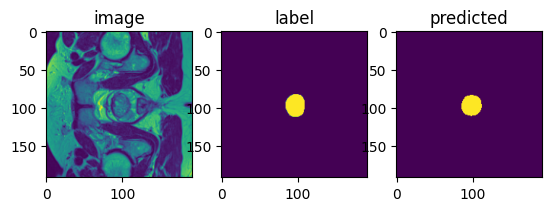

In [182]:
test_gen = my_segmentation_data_generator(batch_size, x_shape, y_shape, test_file_names, images_file_path, masks_file_path)


test_batch_x, test_batch_y = next(test_gen)

def my_prostate_segmentation_function(image):

  classification = np.array(classification_model(image), dtype=np.int32)
  classification = np.round(classification)

  if classification == 0:
    return None

  else:
    segmentation = segmentation_model(image)
    segmentation = np.array(segmentation)
    segmentation = segmentation>0.5
    return segmentation

index = 0

segmentation = my_prostate_segmentation_function(test_batch_x[index:index+1])

if segmentation is None:
  segmentation = np.zeros(y_shape)

fig, (ax1, ax2, ax3) = plt.subplots(1,3)

ax1.imshow(test_batch_x[index])
ax1.set_title('image')

ax2.imshow(test_batch_y[index])
ax2.set_title('label')

ax3.imshow(np.squeeze(segmentation))
ax3.set_title('predicted')
